In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
# !pip install pyarrow

### Question 1: Number of records in Jan 2021 FHV data

In [9]:
'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet'
'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'

'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'

In [14]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df.shape

(3066766, 19)

In [15]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [32]:
df.isna().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
duration                     0
dtype: int64

### Question 2: Average duration in Jan 2021 FHV*

In [22]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration

0         0 days 00:08:26
1         0 days 00:06:19
2         0 days 00:12:45
3         0 days 00:09:37
4         0 days 00:10:50
                ...      
3066761   0 days 00:13:59
3066762   0 days 00:19:27
3066763   0 days 00:24:31
3066764   0 days 00:13:00
3066765   0 days 00:14:24
Name: duration, Length: 3066766, dtype: timedelta64[ns]

In [23]:
df.duration = [i.total_seconds()/60 for i in df.duration]
df.duration.std()

42.594351241920904

### Question 3: Fraction of missing values*

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='duration'>

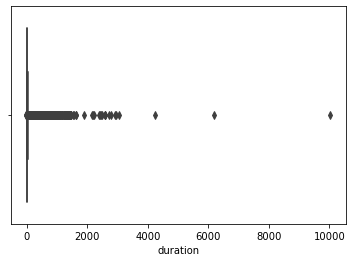

In [24]:
# Check the distribution of the duration variable. There are some outliers.
sns.boxplot(df.duration)

In [25]:
# Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
new_df = df[(df.duration >= 1) & (df.duration <= 60)]
new_df.shape

(3009173, 20)

- Before: 3066766 rows, 20 cols
- After: 3009173 rows, 20 cols

In [26]:
# How many records did you drop?
print(f'{df.shape[0] - new_df.shape[0]} records where dropped.')

57593 records where dropped.


In [27]:
# Let's replace them with "-1".
new_df.fillna(-1, inplace=True)

/tmp/ipykernel_15536/3045629450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.fillna(-1, inplace=True)


In [37]:
new_df[new_df==-1]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,NaN,NaT,NaT,-1.0,NaN,-1.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN
3066762,NaN,NaT,NaT,-1.0,NaN,-1.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN
3066763,NaN,NaT,NaT,-1.0,NaN,-1.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN
3066764,NaN,NaT,NaT,-1.0,NaN,-1.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN


In [41]:
# What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.
print(f"{100 - round((list(new_df['passenger_count'].values).count(-1)/len(new_df))*100, 2)}%")

97.64%


## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries
- Fit a dictionary vectorizer
- Get a feature matrix from it
- What's the dimensionality of this matrix? (The number of columns).

In [42]:
categorical = ['PULocationID', 'DOLocationID']
# numerical = ['SR_Flag']

In [43]:
new_df[categorical] = new_df[categorical].astype(str)

/tmp/ipykernel_15536/4095662405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[categorical] = new_df[categorical].astype(str)


In [44]:
train_dicts = new_df[categorical].to_dict(orient='records')

In [45]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = new_df[target].values

In [46]:
# What's the dimensionality of this matrix? (The number of columns).
X_train.shape

(3009173, 515)

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.649261027855596

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


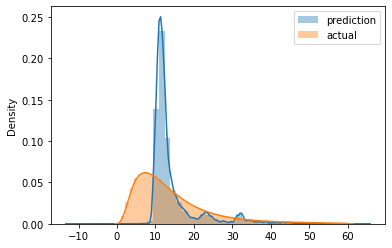

In [48]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [52]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    df.fillna(-1, inplace=True)

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [53]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')
len(df_train), len(df_val)

(3009173, 2855951)

In [54]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [61]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [62]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [63]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.198295479690269

In [59]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [60]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.396168478432612